In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import importlib
from functions import *
import random
import folium
from GA import GeneticMetroPlanner;
from shapely.geometry import Polygon
import ast
import json

# 1) DATASETS and Data Cleaning

## a) Population Dataset

In [3]:
population_path = "/home/saydam/Desktop/2024-2025_itu/yzv202/project/github/datasets/population_with_coordinates.csv"

In [4]:
raw_population_df = pd.read_csv(population_path , header=None, sep=",")
raw_population_df = raw_population_df.dropna(how='all', axis=1)
raw_population_df.columns = raw_population_df.iloc[0]
raw_population_df = raw_population_df.drop(index=0).reset_index(drop=True)
raw_population_df = raw_population_df.loc[:, raw_population_df.columns.notna()]
raw_population_df[['latitude', 'longitude']] = raw_population_df['coordinate'].str.split(',', expand=True)
raw_population_df['latitude'] = raw_population_df['latitude'].astype(float)
raw_population_df['longitude'] = raw_population_df['longitude'].astype(float)
raw_population_df['population'] = raw_population_df['population'].astype(int)
population_df = raw_population_df[['population', 'neighborhood', 'township', 'neighborhood_code', 'latitude', 'longitude']]
population_df = population_df.dropna()

In [5]:
population_df.rename(columns={'neighborhood_code' : 'neighborhood_id'} , inplace=True)

In [6]:
population_df.head()

,population,neighborhood,township,neighborhood_id,latitude,longitude
0,4693,Adnan Menderes,Arnavutköy,40490,41.211179,28.700163
1,47828,Anadolu,Arnavutköy,99359,41.186036,28.749463
2,23116,Arnavutköy Merkez,Arnavutköy,40478,41.182546,28.737891
3,10566,Atatürk,Arnavutköy,40482,41.190149,28.760125
4,12829,Boğazköy İstiklal,Arnavutköy,40483,41.183488,28.768235


In [7]:
population_df.describe()

,population,latitude,longitude
count,708.000000,708.000000,708.000000
mean,21397.411017,41.029966,28.972329
std,15943.770157,0.071404,0.193073
min,2025.000000,40.817868,28.409171
25%,10279.250000,40.998081,28.854917
50%,17970.000000,41.028968,28.981120
75%,28527.750000,41.063456,29.109349
max,112367.000000,41.269994,29.386538


## b) Metro Station Dataset

In [8]:
stations_gdf = gpd.read_file("/home/saydam/Desktop/2024-2025_itu/yzv202/project/github/datasets/station.geojson")

In [9]:
stations_gdf["lat"] = stations_gdf.geometry.x
stations_gdf["lon"] = stations_gdf.geometry.y
stations_df = stations_gdf[["ISTASYON", "PROJE_ADI", "HAT_TURU", "lat", "lon"]]
stations_df[["lat", "lon"]] = stations_df[["lon", "lat"]]

/tmp/ipykernel_157929/509794445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df[["lat", "lon"]] = stations_df[["lon", "lat"]]


In [10]:
stations_df.head()

,ISTASYON,PROJE_ADI,HAT_TURU,lat,lon
0,Mehmet Akif,T1 Kabataş - Bağcılar Tramvay Hattı,Tramvay,41.005800,28.881681
1,Soğanlık,M4 Kadıköy - SGH Metro Hattı,Metro,40.913288,29.192398
2,Aksaray,M1A Yenikapı - Atatürk Havalimanı Metro Hattı,Metro,41.012008,28.948090
3,Olimpiyat,M9 Bahariye - Olimpiyat Metro Hattı,Metro,41.079466,28.767234
4,Sağmalcılar-Pancar Motor,T4 Topkapı - Mescid-i Selam Tramvay Hattı,Tramvay,41.057280,28.906940


# Visulation
Initial maps

In [11]:
istanbul_coords = [41.0082, 28.9784]


map_istanbul = folium.Map(location=istanbul_coords, zoom_start=11, tiles='CartoDB positron')

for index, row in stations_df.iterrows():
    popup_text = f"{row['ISTASYON']}<br>{row['PROJE_ADI']}"
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=popup_text,
        icon=folium.Icon(color='blue' if row['HAT_TURU'] == 'Metro' else 'green', icon='train')
    ).add_to(map_istanbul)

map_istanbul.save("maps/initial_metro_lines.html")

In [12]:
m = folium.Map(location=istanbul_coords, zoom_start=10 , tiles='CartoDB positron')


for _, row in population_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['neighborhood']} ({row['township']})\nNüfus: {row['population']}",
        tooltip=row['neighborhood']
    ).add_to(m)

m.save("maps/neighborhood.html")

# Calculating grids
These are going to be candidate stations

In [13]:
with open("coordinates/coordinates_europe.txt" , "r") as file:
    lines_eu = file.readlines()

In [14]:
coordinates_eu = []
for line in lines_eu:
    line = line.strip()
    if not line:
        continue  # boş satırı atla
    try:
        lon, lat = map(float, line.split(","))
        coordinates_eu.append((lon, lat))  # GeoJSON: [longitude, latitude]
    except ValueError:
        print(f"Geçersiz satır atlandı: {line}")

In [15]:
print(len(coordinates_eu))

45


In [16]:
if coordinates_eu[0] != coordinates_eu[-1]:
    coordinates_eu.append(coordinates_eu[0])


In [17]:
polygon_eu = Polygon(coordinates_eu)

In [18]:
grid_eu = create_grid_for_polygon(polygon_eu)

In [19]:
grid_df_eu = pd.DataFrame(grid_eu)

In [20]:
grid_df_eu.head()

,station_id,lat,lon
0,1,41.083030,28.960897
1,2,41.006031,28.785216
2,3,41.042917,28.902613
3,4,41.073208,28.783443
4,5,41.021031,28.948473


In [21]:
m = folium.Map(location=istanbul_coords, zoom_start=10, tiles='CartoDB positron')

for _, row in grid_df_eu.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],  
        popup=f"station id: {row['station_id']}"
    ).add_to(m)

m.save("maps/grid_eu.html")

In [22]:
with open("coordinates/coordinates_asia.txt" , "r") as file:
    lines_as = file.readlines()

In [23]:
coordinates_as = []
for line in lines_as:
    line = line.strip()
    if not line:
        continue  # boş satırı atla
    try:
        lon, lat = map(float, line.split(","))
        coordinates_as.append((lon, lat))  # GeoJSON: [longitude, latitude]
    except ValueError:
        print(f"Geçersiz satır atlandı: {line}")

In [24]:
print(len(coordinates_as))

34


In [25]:
if coordinates_as[0] != coordinates_as[-1]:
    coordinates_as.append(coordinates_as[0])

In [26]:
polygon_as = Polygon(coordinates_as)

In [27]:
grid_as = create_grid_for_polygon(polygon_as)

In [28]:
grid_df_as = pd.DataFrame(grid_as)

In [29]:
grid_df_as['station_id'] += 1000

In [30]:
grid_df_as.head()

,station_id,lat,lon
0,1001,40.937186,29.137416
1,1002,41.018702,29.079115
2,1003,41.006971,29.075719
3,1004,40.816980,29.271840
4,1005,40.945982,29.279874


In [31]:
m = folium.Map(location=istanbul_coords, zoom_start=10, tiles='CartoDB positron')

for _, row in grid_df_as.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],  
        popup=f"station id: {row['station_id']}"
    ).add_to(m)

m.save("maps/grid_as.html")

In [32]:
grid_df = pd.concat([grid_df_eu , grid_df_as] , ignore_index=True)

In [33]:
m = folium.Map(location=istanbul_coords, zoom_start=10, tiles='CartoDB positron')

for _, row in grid_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],  
        popup=f"station id: {row['station_id']}"
    ).add_to(m)

m.save("maps/grid_istanbul.html")

In [34]:
grid_df['TYPE'] = 'candidate'
stations_df['TYPE'] = 'existing'

/tmp/ipykernel_157929/4111902988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['TYPE'] = 'existing'


In [35]:
stations_df.head()

,ISTASYON,PROJE_ADI,HAT_TURU,lat,lon,TYPE
0,Mehmet Akif,T1 Kabataş - Bağcılar Tramvay Hattı,Tramvay,41.005800,28.881681,existing
1,Soğanlık,M4 Kadıköy - SGH Metro Hattı,Metro,40.913288,29.192398,existing
2,Aksaray,M1A Yenikapı - Atatürk Havalimanı Metro Hattı,Metro,41.012008,28.948090,existing
3,Olimpiyat,M9 Bahariye - Olimpiyat Metro Hattı,Metro,41.079466,28.767234,existing
4,Sağmalcılar-Pancar Motor,T4 Topkapı - Mescid-i Selam Tramvay Hattı,Tramvay,41.057280,28.906940,existing


In [36]:
grid_df.head()

,station_id,lat,lon,TYPE
0,1,41.083030,28.960897,candidate
1,2,41.006031,28.785216,candidate
2,3,41.042917,28.902613,candidate
3,4,41.073208,28.783443,candidate
4,5,41.021031,28.948473,candidate


In [37]:
print(grid_df.dtypes)

station_id      int64
lat           float64
lon           float64
TYPE           object
dtype: object


In [38]:
grid_df.describe()

,station_id,lat,lon
count,2000.000000,2000.000000,2000.000000
mean,1000.500000,41.005711,29.010321
std,577.494589,0.072768,0.218575
min,1.000000,40.814709,28.519078
25%,500.750000,40.964023,28.836617
50%,1000.500000,41.007328,29.043649
75%,1500.250000,41.053696,29.200158
max,2000.000000,41.217258,29.388175


In [39]:
all_stations = pd.concat([
    grid_df[['station_id', 'lat', 'lon' , 'TYPE']],
    stations_df[['ISTASYON', 'lat', 'lon' , 'TYPE']].rename(columns={'ISTASYON': 'station_id'})
]).reset_index(drop=True)


In [40]:
all_stations = all_stations.reset_index(drop=True)
all_stations['station_id'] = all_stations.index + 34001

In [41]:
all_stations.tail()

,station_id,lat,lon,TYPE
2338,36339,40.990637,29.104066,existing
2339,36340,40.978350,29.066290,existing
2340,36341,41.042728,29.098798,existing
2341,36342,41.056077,28.813604,existing
2342,36343,41.045517,28.937960,existing


In [42]:
all_stations_neighboor = calculate_arrived_neighborhood_per_station(all_stations , population_df)

In [43]:
all_stations_neighboor.head()

,station_id,lat,lon,TYPE,arrived_neighborhoods
0,34001,41.083030,28.960897,candidate,"{40366, 40543, 40545}"
1,34002,41.006031,28.785216,candidate,"{40595, 40594, 40596, 40604}"
2,34003,41.042917,28.902613,candidate,"{40207, 40213, 40209}"
3,34004,41.073208,28.783443,candidate,{40585}
4,34005,41.021031,28.948473,candidate,"{99143, İ Şerif), 40397, 99142, 99144, 99141, ..."


### Extracting Metro Lines and Stations
We have not a extract metro lines and their stations dictionary. For further operation we need this dict .

In [44]:
TOLERANCE = 0.0005

project_dict = defaultdict(list)

existing_stations = all_stations[all_stations['TYPE'] == 'existing']

for idx, row in stations_df.iterrows():
    proje_adi_full = row['PROJE_ADI']
    lat = row['lat']
    lon = row['lon']

    match_hat = re.search(r'\b(M\d+[A-Z]?|T\d+)\b', proje_adi_full)
    if not match_hat:
        continue  
    hat_kodu = match_hat.group()


    match = existing_stations[
        (existing_stations['lat'].sub(lat).abs() < TOLERANCE) &
        (existing_stations['lon'].sub(lon).abs() < TOLERANCE)
    ]

    if not match.empty:
        for station_id in match['station_id']:
            project_dict[hat_kodu].append(station_id)

project_dict = dict(project_dict)


In [45]:
print(project_dict)

{'T1': [36001, 36017, 36025, 36027, 36031, 36032, 36033, 36055, 36056, 36065, 36066, 36071, 36075, 36094, 36095, 36097, 36101, 36107, 36125, 36126, 36127, 36128, 36131, 36135, 36150, 36151, 36154, 36185, 36193, 36196, 36209, 36224], 'M4': [36002, 36009, 36010, 36038, 36091, 36099, 36110, 36112, 36129, 36134, 36139, 36153, 36157, 36124, 36158, 36162, 36165, 36181, 36186, 36192, 36261, 36262, 36263, 36264, 36265, 36266, 36267, 36268, 36269, 36270], 'M1A': [36003, 36041, 36045, 36047, 36058, 36061, 36069, 36098, 36103, 36133, 36148, 36183, 36184, 36190, 36197, 36199, 36211, 36212, 36214], 'M9': [36004, 36084, 36187, 36160, 36230, 36250, 36283, 36284, 36285, 36286, 36287, 36288, 36326, 36289, 36114, 36290, 36291], 'T4': [36005, 36006, 36023, 36040, 36042, 36048, 36064, 36067, 36068, 36072, 36073, 36074, 36096, 36102, 36108, 36132, 36156, 36163, 36191, 36198, 36210, 36215], 'M5': [36012, 36014, 36079, 36111, 36115, 36118, 36141, 36144, 36147, 36167, 36171, 36173, 36175, 36176, 36177, 36200,

In [46]:
existing_stations_dict = {
    'T1' : [36065 , 36125 , 36025 , 36126 , 36209 , 36055 , 36027 , 36101 , 36094 , 36196 , 36075 , 36071 , 36131,
            36097 , 36154 , 36095 , 36056 , 36031 , 36185 , 36032 , 36127 , 36193 , 36150 , 36135 , 36017 , 36224,
            36128 , 36033 , 36151 , 36107] ,
    'T4' : [36023 , 36102 , 36064 ,36132 ,36096 ,36210 ,36067 ,36072 ,36005 ,36191, 36068 ,36048, 36006, 36156, 36198, 36215 ,
            36073 , 36040 ,36163 ,36074 ,36108 ,36042] ,
    'T5' : [36314  ,36282 ,36022 ,36039 ,36155 ,36225 ,36343 ,36059 ,36226 ,36227 ,36018 ,36019 ,36020],
    'M1A' : [36061  ,36003 ,36190 ,36183 ,36058 ,36214 ,36047 ,36041 ,36045 ,36212 ,36098 ,36184 ,36197, 36103 ,
             36211 ,36133 ,36069, 36199, 36148],
    'M1B' : [36152 ,36136  ,36195 ,36138 ,36026 ,36276, 36275 ,36326, 36279 ,36321 ,36316 ,36322 ,36319, 36313],
    'M2' : [36194 ,36105 ,36109, 36164 ,36149 ,36182 ,36166 ,36063 ,36030 ,36044 ,36216, 36060, 36090,36089, 36104],
    'M3' : [36311, 36281 ,36280 ,36274 ,36312, 36278 ,36278 ,36106 ,36070 ,36137 ,36230 ,36189 ,36028, 36043, 36328,
            36329, 36330 ,36327 ,36161],
    'M4' : [36165,  36158 ,36157 ,36038 ,36192 ,36099 ,36129, 36110 ,36162 ,36091 ,36134 ,36153, 36186 ,36181 ,36002 ,36139,
            36010 ,36009, 36112 ,36261  ,36270 ,36269 ,36268, 36267],
    'M5' : [36014 , 36115 ,36118 ,36175 ,36144 ,36141 ,36111, 36012, 36200 ,36079 ,36176, 36173 ,36171 ,36147, 36167, 36177 ,
            36259 ,36217, 36255, 36258, 36260, 36254 ,36257 ,36256],
    'M6' : [36159 , 36049 ,36188 ,36140],
    'M7' : [36220 , 36221 ,36219 ,36082 ,36146 ,36080, 36203 ,36207 ,36053 ,36116 ,36170 ,36113 ,36121, 36078 ,36143 ,36052,
            36015, 36037, 36342 ,36302 ,36306 ,36308 ,36304 ,36305 ,36303 ,36307, 36310 ,36309 ,36222],
    'M8' : [36295, 36296, 36294, 36293 ,36299 ,36292 ,36297 ,36218, 36271 ,36300 ,36298 ,36273 ,36272],
    'M9' : [36114 ,36289 ,36285 ,36287, 36284 ,36286 ,36250 ,36084 ,36283 ,36187 ,36004],
    'M10' : [36252 ,36251 ,36263, 36264 ,36262 ,36265 ,36266],
    'M11' : [36247 , 36240 ,36246 ,36244 ,36245, 36241 ,36243 ,36242 ,36324 ,36325 ,36323,36318, 36320 ,36315],
    'M12' : [36331 ,36340 ,36336 ,36334 ,36339 ,36335 ,36338 ,36333 ,36332 ,36337, 36341]}
            

we dont know last stations of metro lines. i added last station end of the metro line array.

In [47]:
m_aqqq = visualize_chromosome_new(existing_stations_dict , all_stations)
m_aqqq.save('maps/initial_metro_with_lines.html')

In [48]:
m_old = visualize_chromosome(existing_stations_dict , all_stations)
m_old.save("maps/initial_metro_with_color.html")

we should calculate the connectivitiy dictionary . this dict shows which station could be connected whichs stations 

In [49]:
connectivity_dict = calculate_connectivity_dict(all_stations)

In [50]:
print(len(connectivity_dict))

2340


# GA

In [51]:
GeneticAlgorithm = GeneticMetroPlanner(
    all_stations_df = all_stations_neighboor,
    neighborhood_df=population_df,
    connectivity_dict = connectivity_dict,
    existing_lines_dict = existing_stations_dict,
    mutation_line_rate=1)

In [52]:
for line , stations in existing_stations_dict.items():
    print(f"{line}:  {len(stations)} station")

T1:  30 station
T4:  22 station
T5:  13 station
M1A:  19 station
M1B:  14 station
M2:  15 station
M3:  19 station
M4:  24 station
M5:  24 station
M6:  4 station
M7:  29 station
M8:  13 station
M9:  11 station
M10:  7 station
M11:  14 station
M12:  11 station


In [53]:
chromosome = GeneticAlgorithm.add_metro_stations(existing_stations_dict)
for line, stations in chromosome.items():
    print(f"{line}: {len(stations)} station")

T1: 30 station
T4: 23 station
T5: 14 station
M1A: 21 station
M1B: 14 station
M2: 16 station
M3: 20 station
M4: 25 station
M5: 26 station
M6: 6 station
M7: 31 station
M8: 14 station
M9: 13 station
M10: 7 station
M11: 16 station
M12: 11 station


In [54]:
print(chromosome)

{'T1': [36065, 36125, 36025, 36126, 36209, 36055, 36027, 36101, 36094, 36196, 36075, 36071, 36131, 36097, 36154, 36095, 36056, 36031, 36185, 36032, 36127, 36193, 36150, 36135, 36017, 36224, 36128, 36033, 36151, 36107], 'T4': [36023, 36102, 36064, 36132, 36096, 36210, 36067, 36072, 36005, 36191, 36068, 36048, 36006, 36156, 36198, 36215, 36073, 36040, 36163, 36074, 36108, 36042, 34553], 'T5': [36314, 36282, 36022, 36039, 36155, 36225, 36343, 36059, 36226, 36227, 36018, 36019, 36020, 34766], 'M1A': [36061, 36003, 36190, 36183, 36058, 36214, 36047, 36041, 36045, 36212, 36098, 36184, 36197, 36103, 36211, 36133, 36069, 36199, 36148, 34925, 34481], 'M1B': [36152, 36136, 36195, 36138, 36026, 36276, 36275, 36326, 36279, 36321, 36316, 36322, 36319, 36313], 'M2': [36194, 36105, 36109, 36164, 36149, 36182, 36166, 36063, 36030, 36044, 36216, 36060, 36090, 36089, 36104, 34973], 'M3': [36311, 36281, 36280, 36274, 36312, 36278, 36278, 36106, 36070, 36137, 36230, 36189, 36028, 36043, 36328, 36329, 3633

In [56]:
print(GeneticAlgorithm.calculate_transfer_number(chromosome))

25


In [57]:
m_n = visualize_chromosome_new(chromosome , all_stations)

In [58]:
m_n.save("maps/chromosome_map_first_iteration.html")

In [59]:
print(GeneticAlgorithm.calculate_population_for_chromosome(chromosome))

8582157.000000002


In [60]:
GeneticAlgorithm.generate_initial_population()

In [61]:
print(len(GeneticAlgorithm.population))

10


In [62]:
GeneticAlgorithm.fitness()

In [63]:
print(GeneticAlgorithm.fitness_values)

[np.float64(4.5766614981629115), np.float64(5.7724452304469756), np.float64(4.371724954587023), np.float64(4.859489791264341), np.float64(4.295872003368332), np.float64(5.403105223692548), np.float64(5.397488450124917), np.float64(5.649668109762416), np.float64(4.451573505704289), np.float64(4.4905196869749)]


# Implementation

In [155]:
planner = GeneticMetroPlanner(
    all_stations_df=all_stations_neighboor,
    neighborhood_df=population_df,
    connectivity_dict=connectivity_dict,
    existing_lines_dict=existing_stations_dict,
    mutation_rate=0.1,
    mutation_line_rate=0.2,
    generation_number=20,
    child_number=20,
    max_per_station=2,
    verbose=True
)


In [156]:
planner.run()

Algorithm is started.
--------------------
Generation 1:
Best Fitness: 99.56
Population Coverage: 6325041.0
Cost: 7
Transfers: 24
--------------------

--------------------
Generation 2:
Best Fitness: 78.67
Population Coverage: 6438051.000000002
Cost: 9
Transfers: 24
--------------------

--------------------
Generation 3:
Best Fitness: 77.70
Population Coverage: 6359395.000000002
Cost: 9
Transfers: 24
--------------------

--------------------
Generation 4:
Best Fitness: 89.05
Population Coverage: 6470796.0
Cost: 8
Transfers: 24
--------------------

--------------------
Generation 5:
Best Fitness: 87.59
Population Coverage: 6365925.000000003
Cost: 8
Transfers: 24
--------------------

--------------------
Generation 6:
Best Fitness: 141.43
Population Coverage: 6401882.0
Cost: 5
Transfers: 25
--------------------

--------------------
Generation 7:
Best Fitness: 79.34
Population Coverage: 6489394.000000004
Cost: 9
Transfers: 25
--------------------

--------------------
Generation 8:


In [157]:
planner.details()

Population : 7352620.0
Cost : 77
The number of transfer stations : 38
The number of initial metro lines : 16 | The number of result metro lines : 37 
The number of initial metro stations : 268 | The number of result metro stations : 338


In [163]:
m_final = visualize_chromosome_new(planner.best_chromosome , all_stations)

In [164]:
m_final.save('maps/final_metro_lines.html')

In [165]:
print(len(planner.history))

20


In [166]:
m_best = visualize_chromosome_new(planner.best_chromosome_all_time , all_stations)
m_best.save('maps/best_metro_lines.html')


# Plots

In [167]:
history_df = pd.DataFrame(planner.history)
history_df['generation'] = range(len(history_df))

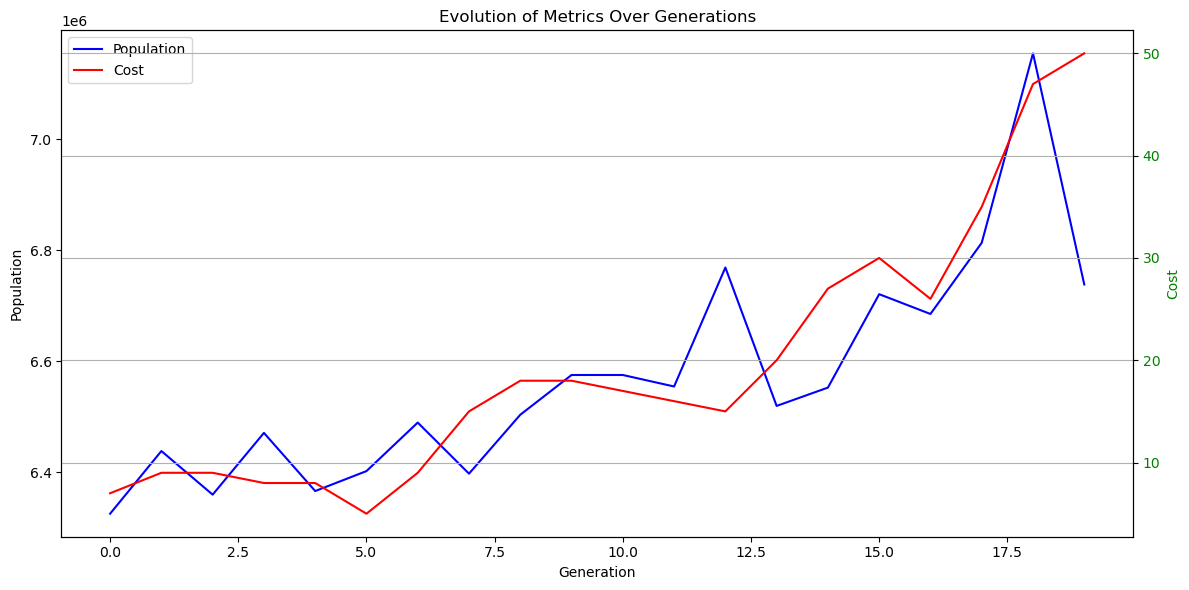

In [168]:
fig, ax1 = plt.subplots(figsize=(12,6))

# İlk y-ekseni (population ve cost gibi büyük değerler)
ax1.plot(history_df['generation'], history_df['population'], 'b-', label='Population')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Population', color='black')
ax1.tick_params(axis='y')

# İkinci y-ekseni (fitness gibi küçük değerler)
ax2 = ax1.twinx()
ax2.plot(history_df['generation'], history_df['cost'], 'r-', label='Cost')
ax2.set_ylabel('Cost', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Legend için her iki eksenin etiketlerini birleştirelim
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Evolution of Metrics Over Generations")
plt.grid(True)
plt.tight_layout()
plt.show()

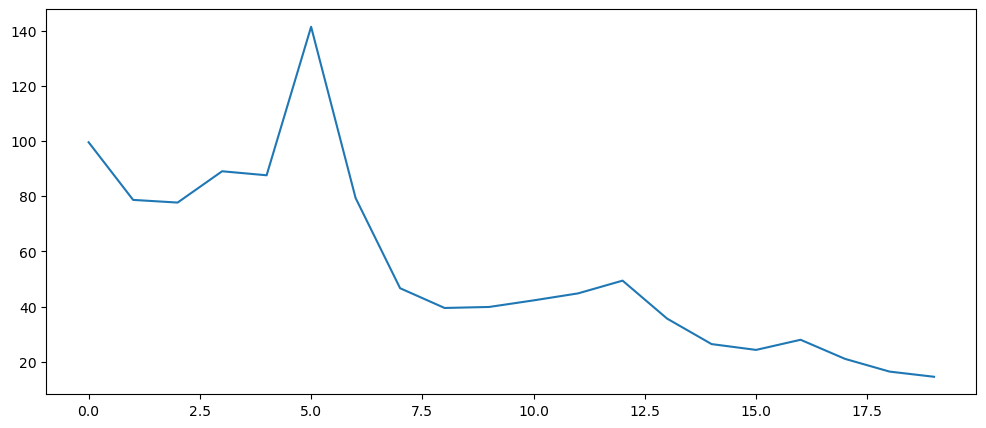

In [170]:
plt.figure(figsize=(12 , 5))

plt.plot(history_df['generation'] , history_df['fitness'])

# Try for Multiple GA

In [195]:
array_GA = []

for i in range(5):
    temp_planner = GeneticMetroPlanner(
    all_stations_df=all_stations_neighboor,
    neighborhood_df=population_df,
    connectivity_dict=connectivity_dict,
    existing_lines_dict=existing_stations_dict,
    mutation_rate=0.1,
    mutation_line_rate=0.2,
    generation_number=10,
    child_number=30,
    max_per_station=3,
    verbose=False,
    random_seed=i*10
    )
    array_GA.append(temp_planner)

In [196]:
multiple_history = []
for GA in array_GA:
    GA.run()
    temp_history_df = pd.DataFrame(GA.history)
    temp_history_df['generation'] = range(len(temp_history_df))
    multiple_history.append(temp_history_df)

Algorithm is started.
Optimization completed.
Algorithm is started.
Optimization completed.
Algorithm is started.
Optimization completed.
Algorithm is started.
Optimization completed.
Algorithm is started.
Optimization completed.


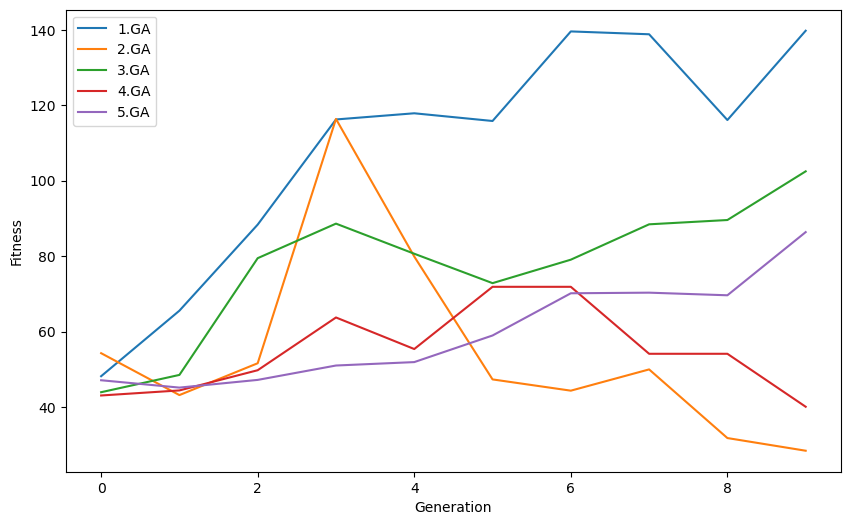

In [197]:
plt.figure(figsize=(10,6))
i = 1
for GA_history in multiple_history:
    plt.plot(GA_history['generation'] , GA_history['fitness'] , label =f"{i}.GA")
    i += 1
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

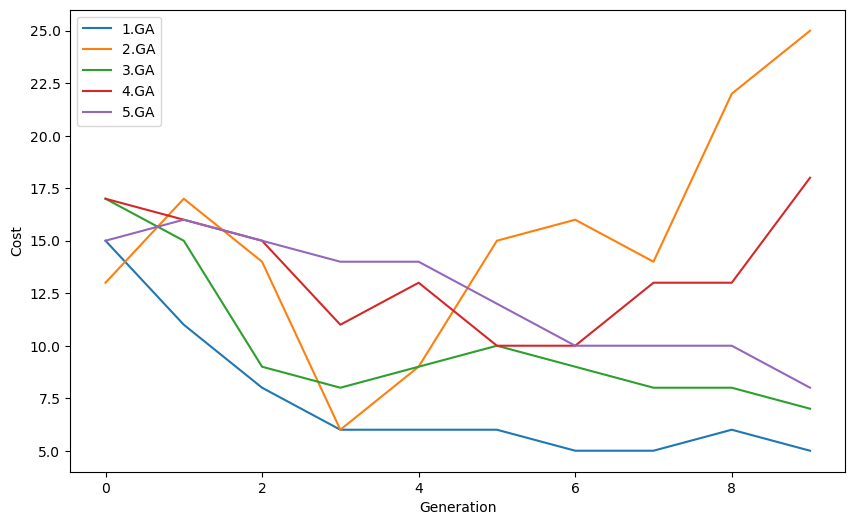

In [198]:
plt.figure(figsize=(10,6))
i = 1
for GA_history in multiple_history:
    plt.plot(GA_history['generation'] , GA_history['cost'] , label =f"{i}.GA")
    i += 1
plt.xlabel('Generation')
plt.ylabel('Cost')
plt.legend()
plt.show()

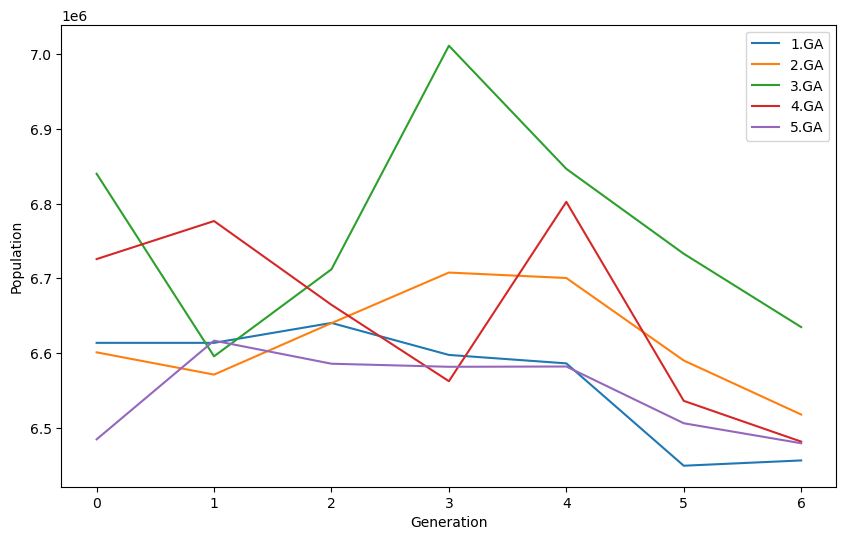

In [192]:
plt.figure(figsize=(10,6))
i = 1
for GA_history in multiple_history:
    plt.plot(GA_history['generation'] , GA_history['population'] , label =f"{i}.GA")
    i += 1
plt.xlabel('Generation')
plt.ylabel('Population')
plt.legend()
plt.show()

In [199]:
i = 0
for GA in array_GA:
    GA_m = visualize_chromosome_new(GA.best_chromosome , all_stations)
    file_name = f"{i}thGA.html"
    i+=1
    GA_m.save('maps/multiple_solutions/' + file_name)